# Overall cell type proportions

In [13]:
import scanpy as sc
from tidyverse.dummy import *
from sctools.composition import compositional_pca, plot_pca_loadings, clustered_heatmap_from_sccoda_CLR
from sctools.scplotting import recolor

import gc
import pertpy as pt

# import sys
# sys.path.append('/users/mstrasse/CRUK-code/')

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams["figure.figsize"] = (4,3)

import sys
sys.path.append('..')
from util import load_original_data
from colormaps import color_dict_diagnosis, cmap_subtypes, cmap_subtypes
from matplotlib.colors import ListedColormap
from prop_utils import annotate_qval_to_scCODA_result, renamer

/tmp/ipykernel_150025/1033007506.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
plotfolder = '/tmp/proportions/overall_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# Create data

In [3]:
adata = load_original_data()
adata = adata[adata.obs.diagnosis.isin(['NE', 'NS', 'M','D','T'])]
adata.raw = adata

/tmp/ipykernel_150025/2178306680.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


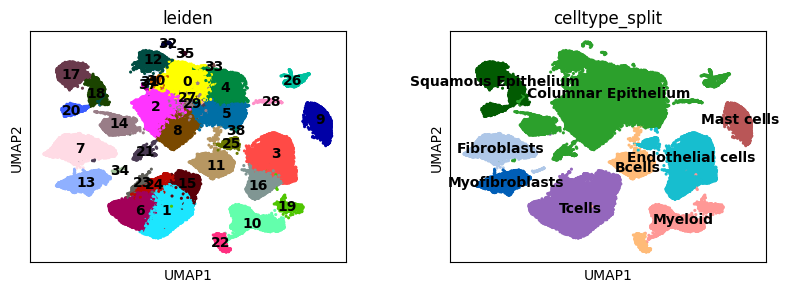

In [4]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['leiden', 'celltype_split'], legend_loc='on data', size=20)

# SCCODA
### on the clusters

In [5]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
]

In [6]:
cluster_name = 'celltype_split'

In [7]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier=cluster_name,
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

In [8]:
for c in data_scanpy_1.var_names:
    data_scanpy_1.obs[f'percent_{c}'] =data_scanpy_1[:,c].X.sum(1) / data_scanpy_1.obs['n_cells']

In [9]:
leiden_color_dict = dict(zip(data_scanpy_1.var_names, adata.uns[f'{cluster_name}_colors'] ))
cmap_reordered = ListedColormap([leiden_color_dict[c] for c in cluster_order])   

order = []
for d in diagnosis_ordered:
    order.extend(sorted(data_scanpy_1.obs.query('diagnosis==@d').index))

/tmp/ipykernel_150025/2536606679.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


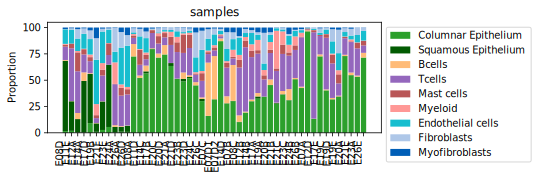

In [10]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(6,2), show=False, palette=cmap_reordered,
    level_order=order
)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/overall_proportions.svg')

In [11]:
set_matplotlib_formats('png')

/tmp/ipykernel_150025/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1884.60it/s]


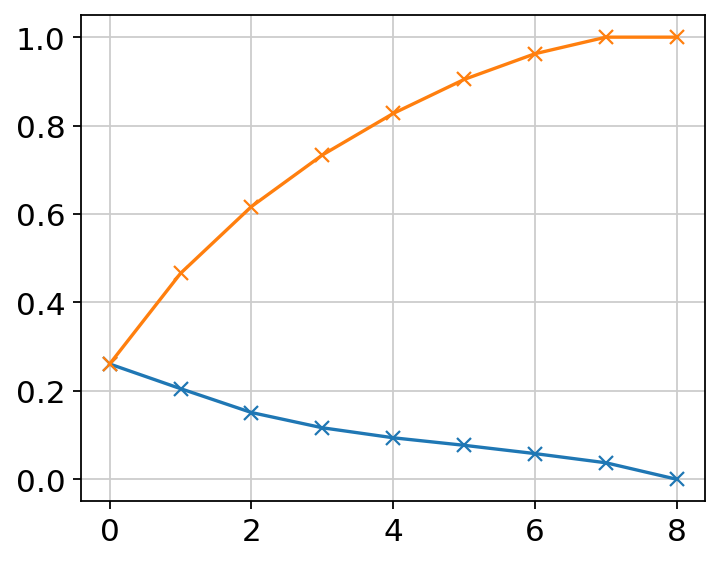

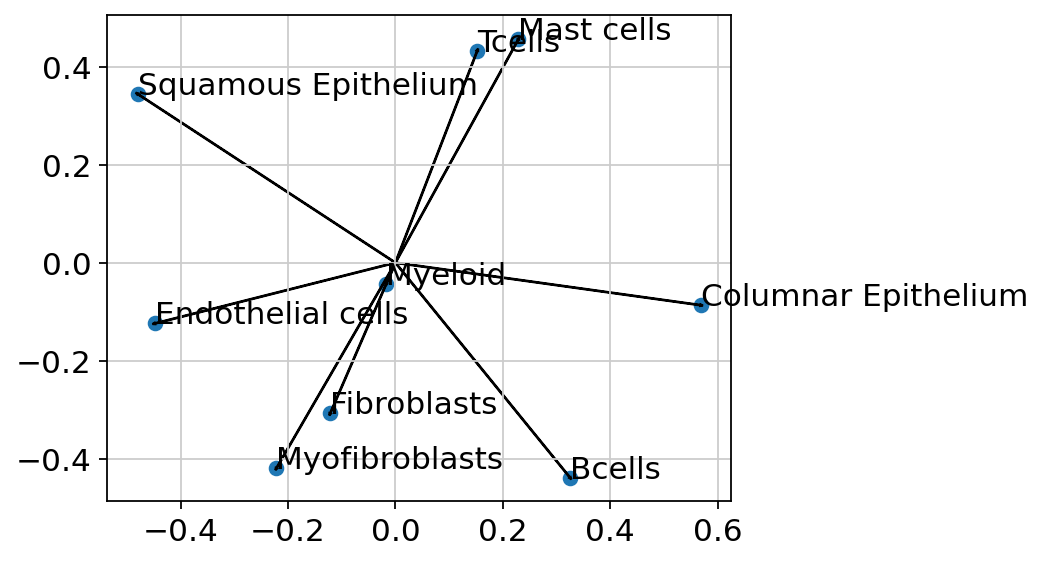

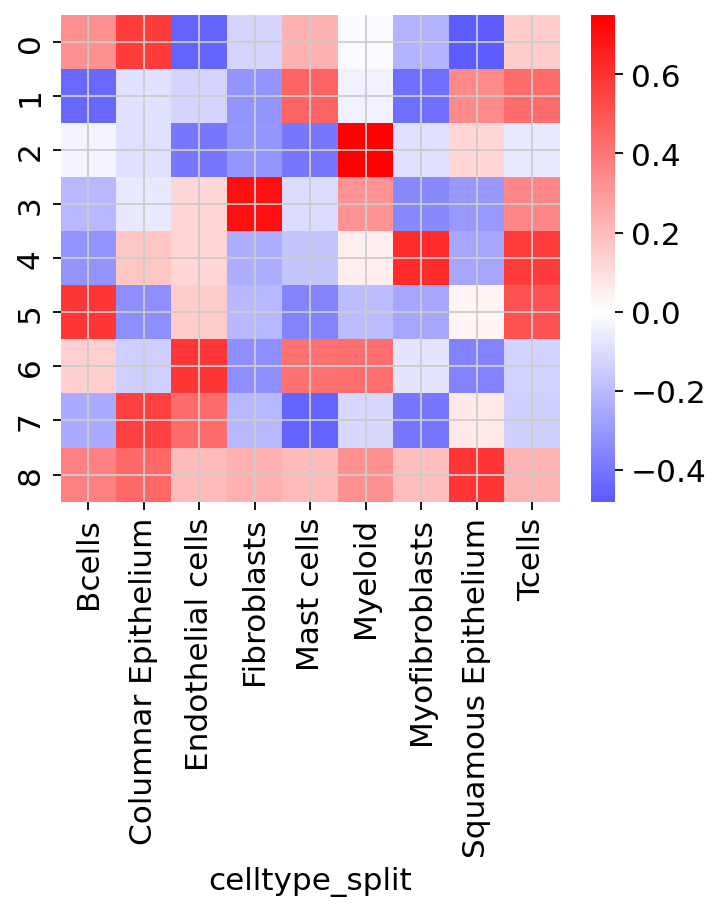

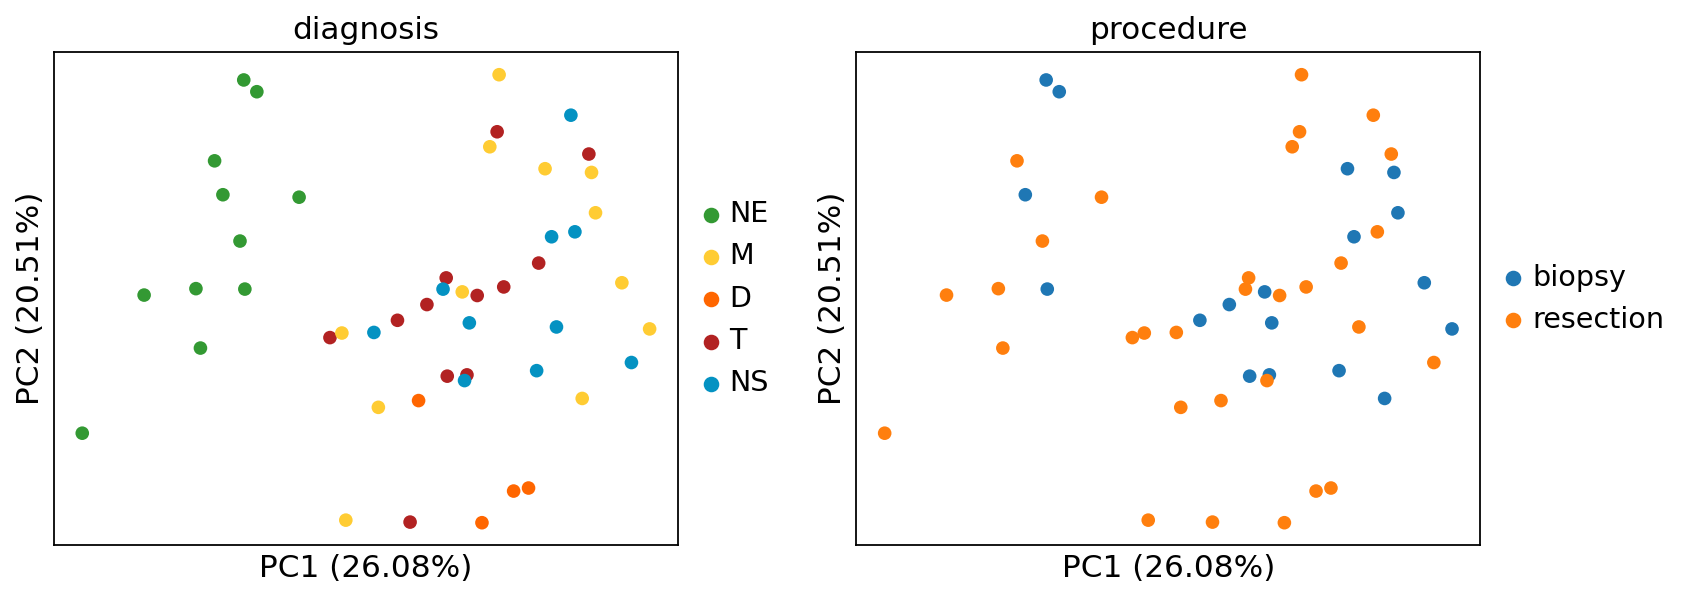

In [30]:
from sctools.composition import clustered_heatmap_from_sccoda_CLR, compositional_pca, plot_pca_loadings
recolor(sccoda_data['coda'], 'diagnosis', color_dict_diagnosis)
sc.set_figure_params(figsize = (5,4))

pca, scaler, x_pca_posterior, principal_components_df = compositional_pca(sccoda_data['coda'])
sccoda_data['coda'].obsm['X_pca'] = x_pca_posterior
sccoda_data['coda'].uns['pca'] = {'variance_ratio': pca.explained_variance_ratio_}

plt.plot(pca.explained_variance_ratio_, 'x-')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'x-')

plt.figure()
plot_pca_loadings(principal_components_df)

plt.figure()
sns.heatmap(principal_components_df, center=0, cmap='bwr')

fig = sc.pl.pca(sccoda_data['coda'], color=['diagnosis','procedure'], size=150, annotate_var_explained=True, show=False, return_fig=True)
# fig.savefig(f'{plotfolder}/pca.svg')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 1851.81it/s]


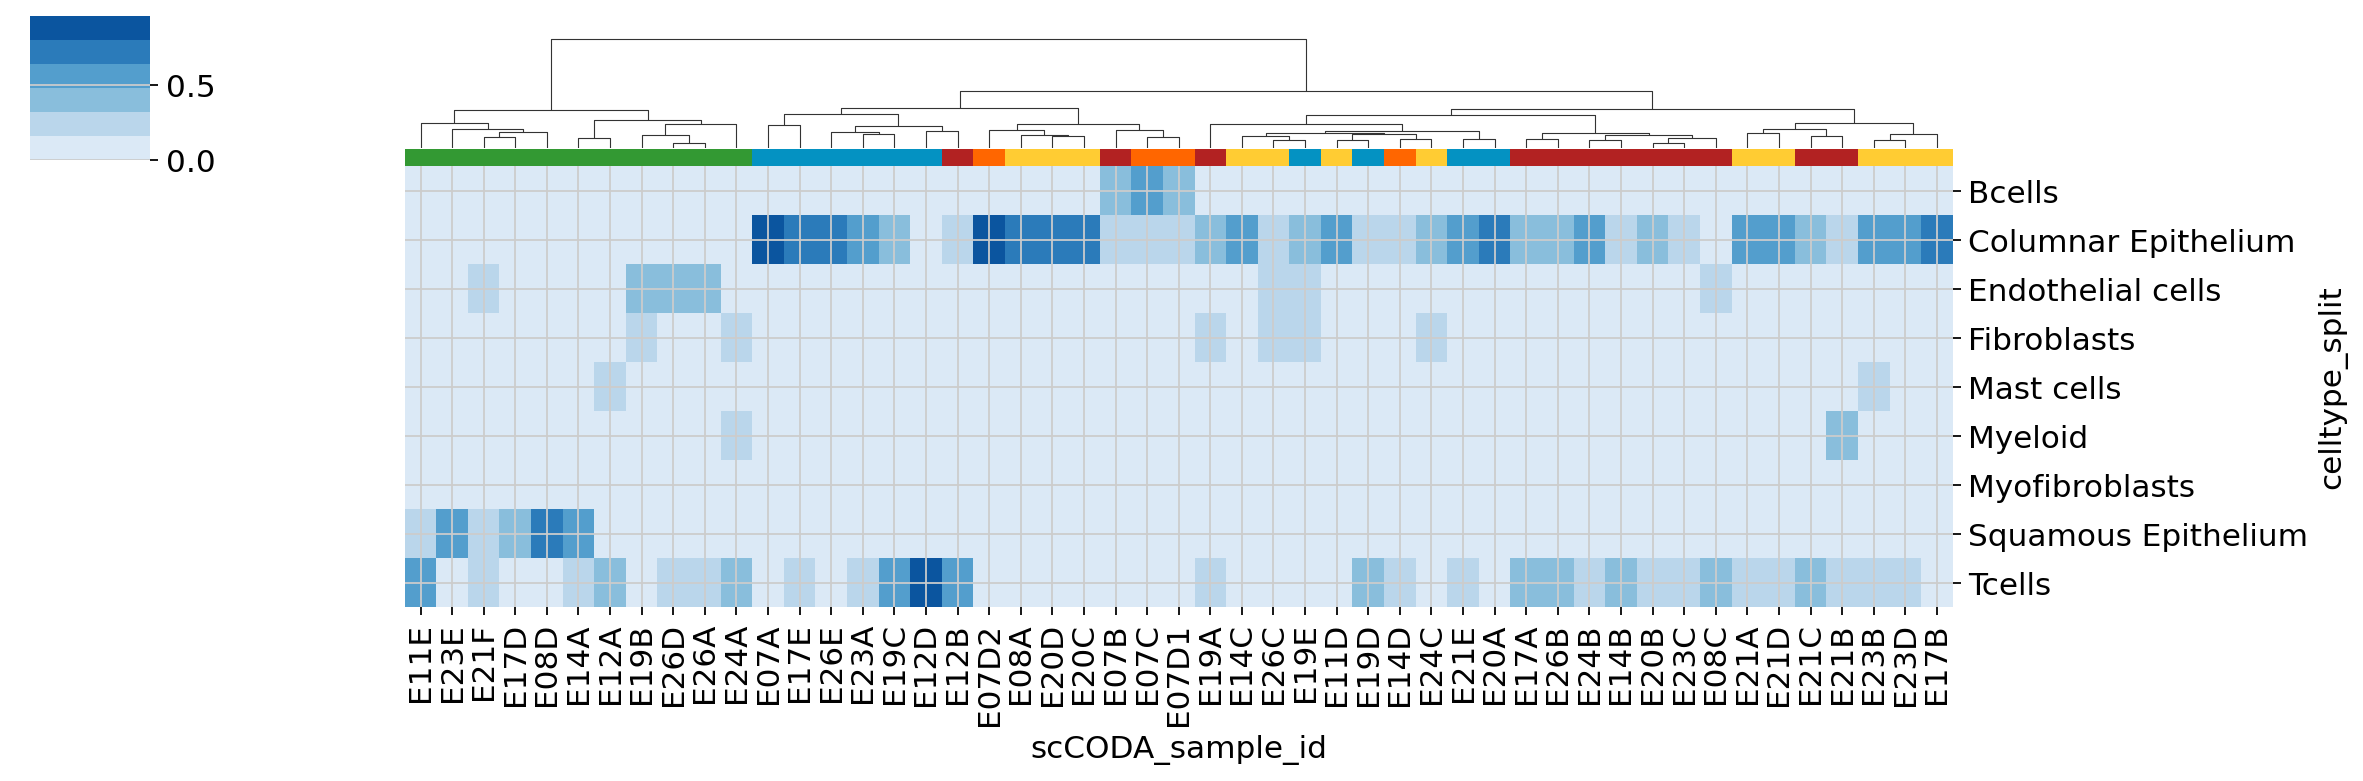

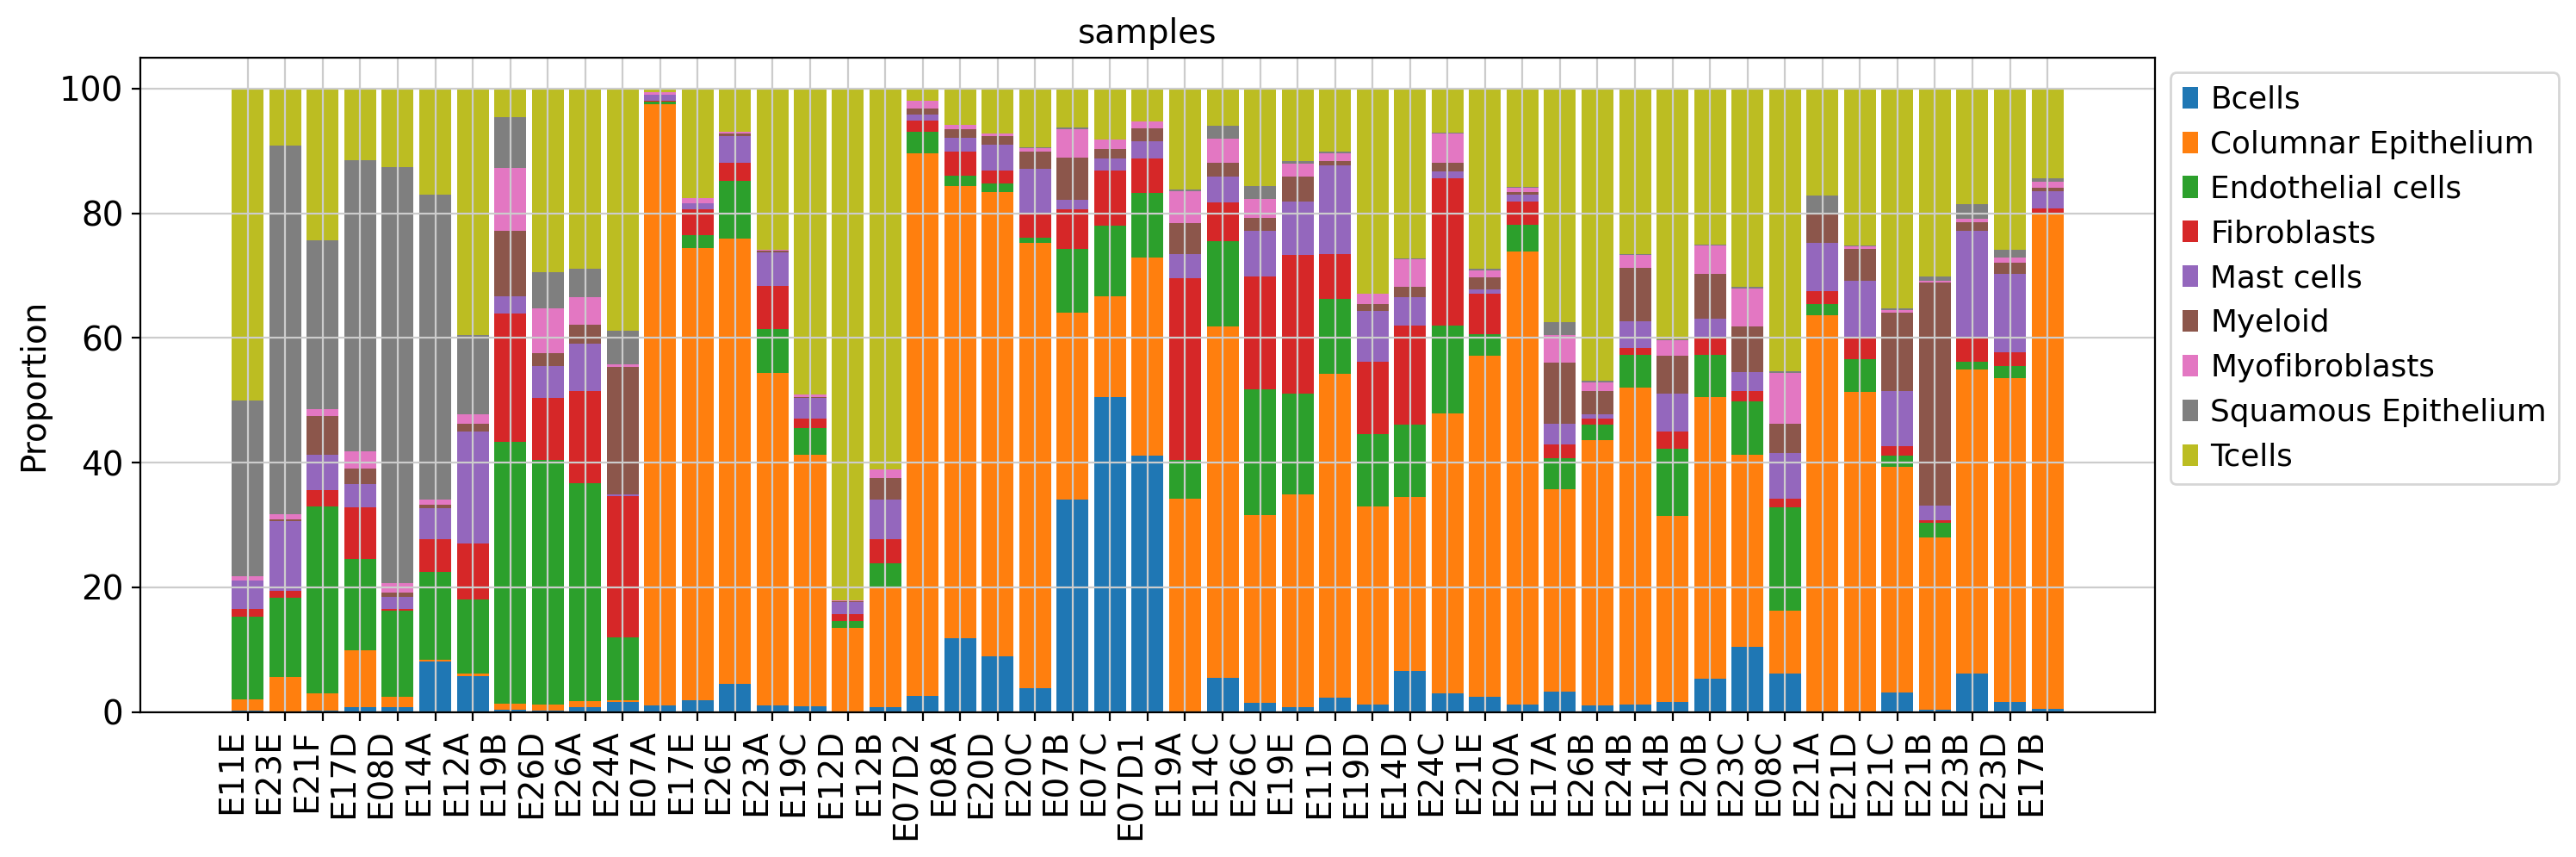

In [32]:
clustered_heatmap_from_sccoda_CLR(sccoda_data['coda'], barcolormap=plt.cm.tab10,  cat_colormaps={'diagnosis': color_dict_diagnosis} );

## Barplots

/tmp/ipykernel_150025/664380124.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_150025/664380124.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


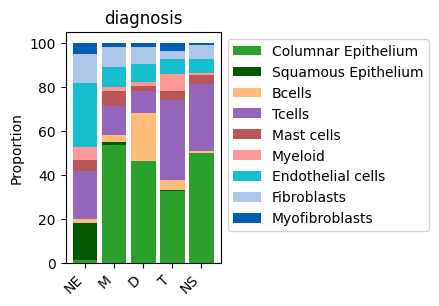

In [18]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data['coda'][:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False, palette=cmap_reordered,
)
fig.figure.savefig(f'{plotfolder}/overall_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/overall_proportions//proportions_per_diagnosis_ncells.svg


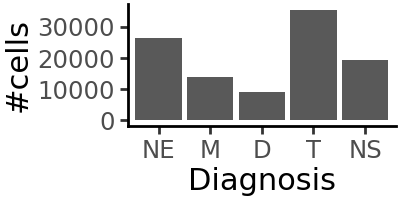

In [19]:
p = pn.ggplot(pd.DataFrame({'n_cells': data_scanpy_1.obs.groupby('diagnosis').n_cells.sum()}).reset_index(), pn.aes(x='diagnosis', y='n_cells')) + pn.geom_bar(stat='identity') \
+ pn.theme_classic() + pn.theme(figure_size=(2,1)) + pn.labs(x='Diagnosis', y='#cells')
p.save(f'{plotfolder}/proportions_per_diagnosis_ncells.svg')
p

/tmp/ipykernel_150025/3113728994.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.1 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/overall_proportions//proportions_per_sample_ncells_NE.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.2000000000000002 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/overall_proportions//proportions_per_sample_ncells_M.svg
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 0.4 x 1 in image.
/opt/c

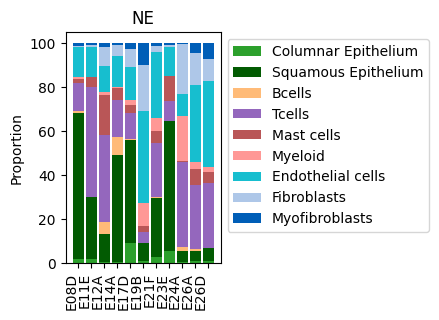

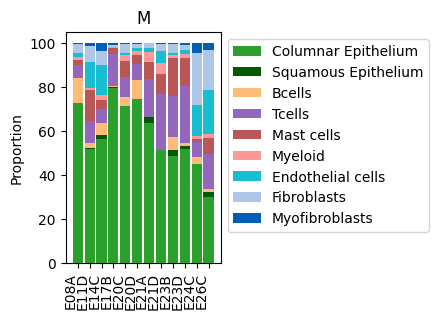

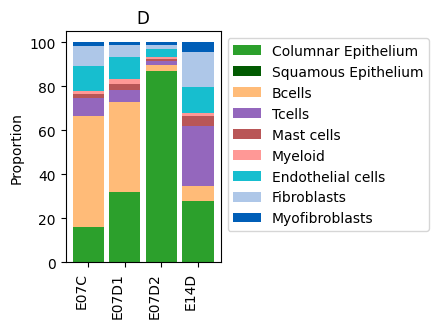

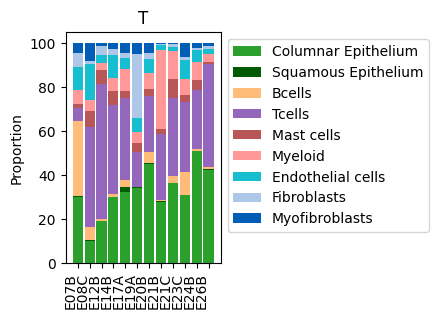

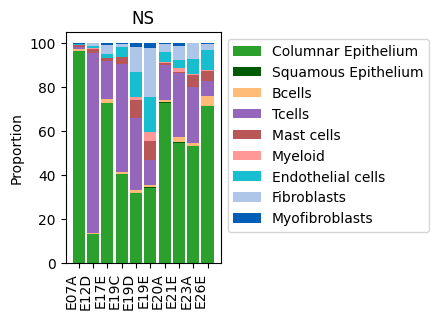

In [20]:
set_matplotlib_formats('svg')
ncell_plots = []
for d in diagnosis_ordered:
    _tmpdata = data_scanpy_1[data_scanpy_1.obs.diagnosis==d, cluster_order]
    width = 0.1 * _tmpdata.shape[0]
    fig = sccoda_model.plot_stacked_barplot(
        _tmpdata,
        modality_key="coda",
        feature_name="samples",
        figsize=(2,3), show=False, palette=cmap_reordered
    )    
    plt.xticks(rotation=90);
    plt.title(f'{d}')
    fig.figure.savefig(f'{plotfolder}/overall_proportions_{d}.svg')
    
    p = pn.ggplot(pd.DataFrame({'n_cells': _tmpdata.obs.groupby('samplename').n_cells.sum()}).reset_index(), pn.aes(x='samplename', y='n_cells')) + pn.geom_bar(stat='identity') \
    + pn.theme_classic() + pn.theme(figure_size=(width,1)) + pn.labs(x='Samplename', y='#cells', title=d) + pn.lims(y=[0,6500])
    p.save(f'{plotfolder}/proportions_per_sample_ncells_{d}.svg')
    ncell_plots.append(p)
set_matplotlib_formats('png')

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


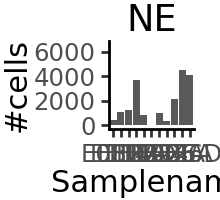

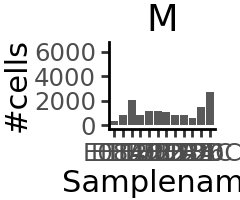

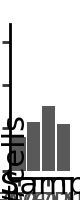

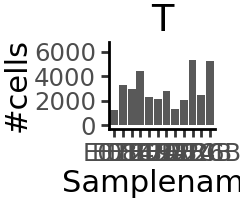

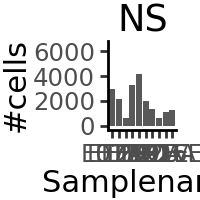

[None, None, None, None, None]

In [21]:
[_.show() for _ in ncell_plots]

In [22]:
q = pd.crosstab(
    pd.Series(pd.Categorical(adata.obs[cluster_name], categories=cluster_order), name=cluster_name, index=adata.obs[cluster_name].index),
    adata.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/tmp/ipykernel_150025/3060290466.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 4 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/overall_proportions//overall_proportions_per_cluster.svg


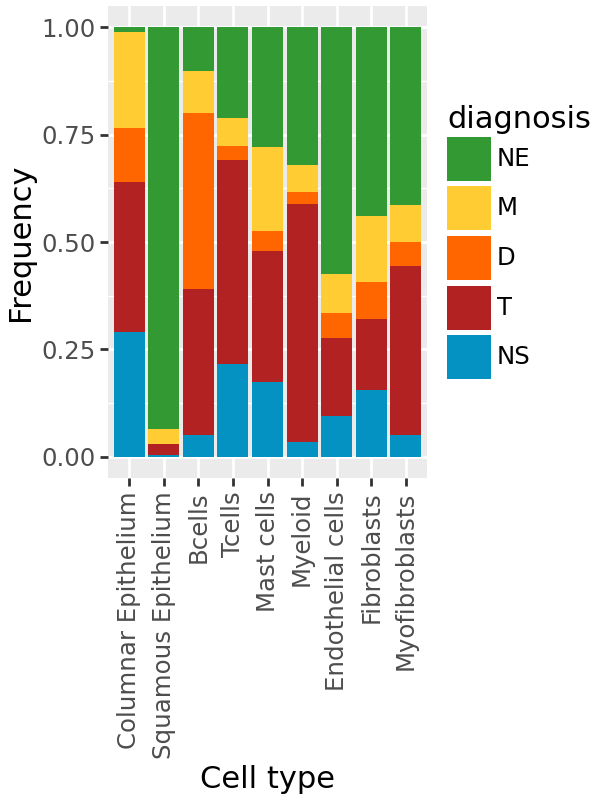

In [23]:
set_matplotlib_formats('svg')
p = pn.ggplot(
    norm_freqs,
    pn.aes(x=cluster_name, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,4), axis_text_x=pn.element_text(rotation=90)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Cell type', y='Frequency')
p.save(f'{plotfolder}/overall_proportions_per_cluster.svg')
p

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/overall_proportions//proportions_per_cluster_ncells.svg


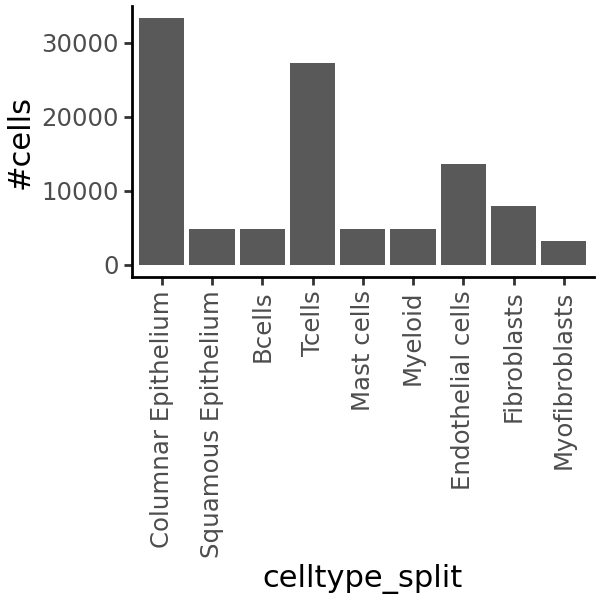

In [24]:
p = pn.ggplot(pd.DataFrame({'n_cells': q.reset_index().melt(id_vars=[cluster_name]).groupby(cluster_name).value.sum()}).reset_index(), pn.aes(x=cluster_name, y='n_cells')) + pn.geom_bar(stat='identity') \
 + pn.theme_classic() + pn.theme(figure_size=(3,3), axis_text_x=pn.element_text(rotation=90)) + pn.labs(x=cluster_name, y='#cells')
p.save(f'{plotfolder}/proportions_per_cluster_ncells.svg')
p

/tmp/ipykernel_150025/2103002924.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


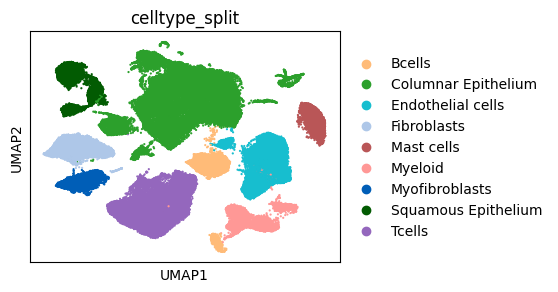

In [25]:
set_matplotlib_formats('png')
sc.pl.umap(adata, color=['celltype_split'], size=10, show=False)
plt.savefig(f'{plotfolder}/Overall_umap.png')

# MCMC

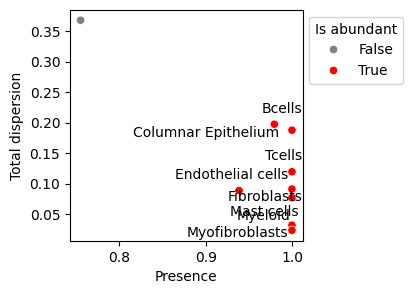

In [26]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, figsize=(3,3)); plt.show()

In [23]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NE')) + procedure+ patient",
    reference_cell_type="Mast cells",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [13:39<00:00, 13.43it/s, 511 steps of size 7.29e-03. acc. prob=0.89]


AnnData object with n_obs × n_vars = 49 × 9
    obs: 'diagnosis', 'patient', 'procedure', 'samplename', 'n_cells', 'percent_Bcells', 'percent_Columnar Epithelium', 'percent_Endothelial cells', 'percent_Fibroblasts', 'percent_Mast cells', 'percent_Myeloid', 'percent_Myofibroblasts', 'percent_Squamous Epithelium', 'percent_Tcells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_procedure[T.resection]', 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]'

In [70]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])
scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)
scCODA_result[scCODA_result['Final Parameter'] != 0]

Final Parameter  \
Covariate                         Cell Type                              
C(diagnosis, Treatment('NE'))T.M  Columnar Epithelium         2.717290   
                                  Squamous Epithelium        -2.252522   
C(diagnosis, Treatment('NE'))T.D  Bcells                      1.182044   
                                  Columnar Epithelium         1.836119   
                                  Squamous Epithelium        -2.480748   
C(diagnosis, Treatment('NE'))T.T  Columnar Epithelium         2.283841   
                                  Myeloid                     1.238766   
                                  Squamous Epithelium        -2.219262   
                                  Tcells                      0.924402   
C(diagnosis, Treatment('NE'))T.NS Columnar Epithelium         3.213616   
                                  Squamous Epithelium        -2.478207   
                                  Tcells                      0.850119   
procedureT.resection              Squamous Epithelium        -0.798794   
                                  Tcells                     -0.761110   
patientT.E12                      Columnar Epithelium        -0.960375   
                                  Tcells                      1.795392   
patientT.E17                      Columnar Epithelium         0.456067   
patientT.E19                      Columnar Epithelium        -0.873629   
                                  Fibroblasts                 0.582376   
patientT.E20                      Columnar Epithelium         0.667515   
patientT.E21                      Myeloid                     1.053891   
                                  Tcells                      1.033603   

                                                       HDI 3%  HDI 97%     SD  \
Covariate                         Cell Type                                     
C(diagnosis, Treatment('NE'))T.M  Columnar Epithelium   2.141    3.259  0.285   
                                  Squamous Epithelium  -3.063   -1.437  0.412   
C(diagnosis, Treatment('NE'))T.D  Bcells                0.142    2.036  0.587   
                                  Columnar Epithelium   0.956    2.619  0.415   
                                  Squamous Epithelium  -3.496   -1.380  0.556   
C(diagnosis, Treatment('NE'))T.T  Columnar Epithelium   1.689    2.867  0.308   
                                  Myeloid               0.650    1.776  0.292   
                                  Squamous Epithelium  -2.946   -1.521  0.365   
                                  Tcells                0.405    1.380  0.239   
C(diagnosis, Treatment('NE'))T.NS Columnar Epithelium   2.484    3.919  0.374   
                                  Squamous Epithelium  -3.235   -1.672  0.393   
                                  Tcells                0.233    1.387  0.331   
procedureT.resection              Squamous Epithelium  -1.405    0.002  0.416   
                                  Tcells               -1.338   -0.221  0.306   
patientT.E12                      Columnar Epithelium  -1.733   -0.113  0.493   
                                  Tcells                1.076    2.496  0.373   
patientT.E17                      Columnar Epithelium  -0.059    1.007  0.334   
patientT.E19                      Columnar Epithelium  -1.563   -0.139  0.408   
                                  Fibroblasts          -0.084    1.244  0.412   
patientT.E20                      Columnar Epithelium  -0.004    1.166  0.347   
patientT.E21                      Myeloid               0.358    1.714  0.389   
                                  Tcells                0.369    1.636  0.350   

                                                       Inclusion probability  \
Covariate                         Cell Type                                    
C(diagnosis, Treatment('NE'))T.M  Columnar Epithelium                 1.0000   
                                  Squamous Epithelium                 1.0000   
C(diagnosis, 

In [25]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_4175614/972804642.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


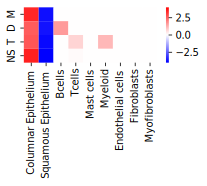

In [26]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/matrix_scCODA.svg')

In [27]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type,Bcells,Columnar Epithelium,Endothelial cells,Fibroblasts,Mast cells,Myeloid,Myofibroblasts,Squamous Epithelium,Tcells
Covariate,,,,,,,,,
D,1.590228,2.533860,-0.115101,-0.115101,-0.115101,-0.115101,-0.115101,-3.694064,-0.115101
M,-0.528886,3.391334,-0.528886,-0.528886,-0.528886,-0.528886,-0.528886,-3.778589,-0.528886
NS,-1.157436,3.478832,-1.157436,-1.157436,-1.157436,-1.157436,-1.157436,-4.732733,0.069027
T,-0.664121,2.630766,-0.664121,-0.664121,-0.664121,1.123041,-0.664121,-3.865839,0.669509
patientT.E08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E12,-1.039282,-2.424810,-1.039282,-1.039282,-1.039282,-1.039282,-1.039282,-1.039282,1.550921
patientT.E14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E17,-0.042600,0.615366,-0.042600,-0.042600,-0.042600,-0.042600,-0.042600,-0.042600,-0.042600


## NS as reference level

In [28]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NS')) + procedure+ patient",
    reference_cell_type="Mast cells",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [15:13<00:00, 12.04it/s, 511 steps of size 9.89e-03. acc. prob=0.83]


AnnData object with n_obs × n_vars = 49 × 9
    obs: 'diagnosis', 'patient', 'procedure', 'samplename', 'n_cells', 'percent_Bcells', 'percent_Columnar Epithelium', 'percent_Endothelial cells', 'percent_Fibroblasts', 'percent_Mast cells', 'percent_Myeloid', 'percent_Myofibroblasts', 'percent_Squamous Epithelium', 'percent_Tcells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_procedure[T.resection]', 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]', "effect_df_C(dia

In [29]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])
scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)

# scCODA_result.to_csv(f'{plotfolder}/MCMC_diag_procedure_patient.csv')
scCODA_result[scCODA_result['Final Parameter'] != 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


Final Parameter  \
Covariate                         Cell Type                              
C(diagnosis, Treatment('NS'))T.NE Columnar Epithelium        -2.786525   
                                  Endothelial cells           0.972354   
                                  Squamous Epithelium         2.712885   
C(diagnosis, Treatment('NS'))T.T  Columnar Epithelium        -0.561990   
                                  Myeloid                     1.155515   
                                  Tcells                      0.587641   
procedureT.resection              Squamous Epithelium        -0.890158   
                                  Tcells                     -0.640165   
patientT.E12                      Tcells                      1.659770   
patientT.E20                      Columnar Epithelium         0.693788   
patientT.E21                      Myeloid                     1.088031   
                                  Tcells                      0.976466   

                                                       HDI 3%  HDI 97%     SD  \
Covariate                         Cell Type                                     
C(diagnosis, Treatment('NS'))T.NE Columnar Epithelium  -3.418   -2.147  0.322   
                                  Endothelial cells     0.427    1.513  0.285   
                                  Squamous Epithelium   2.134    3.298  0.297   
C(diagnosis, Treatment('NS'))T.T  Columnar Epithelium  -0.962    0.001  0.298   
                                  Myeloid               0.589    1.708  0.295   
                                  Tcells                0.063    1.040  0.301   
procedureT.resection              Squamous Epithelium  -1.558   -0.162  0.401   
                                  Tcells               -1.159   -0.069  0.314   
patientT.E12                      Tcells                0.889    2.326  0.375   
patientT.E20                      Columnar Epithelium  -0.018    1.229  0.366   
patientT.E21                      Myeloid               0.339    1.796  0.423   
                                  Tcells                0.288    1.631  0.387   

                                                       Inclusion probability  \
Covariate                         Cell Type                                    
C(diagnosis, Treatment('NS'))T.NE Columnar Epithelium                 1.0000   
                                  Endothelial cells                   0.9846   
                                  Squamous Epithelium                 1.0000   
C(diagnosis, Treatment('NS'))T.T  Columnar Epithelium                 0.8712   
                                  Myeloid                             0.9999   
                                  Tcells                              0.8840   
procedureT.resection              Squamous Epithelium                 0.9510   
                                  Tcells                              0.9325   
patientT.E12                      Tcells                              1.0000   
patientT.E20                      Columnar Epithelium                 0.9259   
patientT.E21                      Myeloid                             0.9682   
                                  Tcells                              0.9731   

                                                       Expected Sample  \
Covariate                         Cell Type                              
C(diagnosis, Treatment('NS'))T.NE Columnar Epithelium        80.093659   
                                  Endothelial cells         369.472251   
                                  Squamous Epithelium       760.218809   
C(diagnosis, Treatment('NS'))T.T  Columnar Epithelium       672.224686   
                                  Myeloid                   165.686529   
                                  Tcells                    758.409658   
procedureT.resection              Squamous Epithelium        20.416308   
                                  Tcells                    241.369165   
patientT.E12          

In [35]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_4175614/4172174983.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


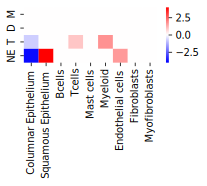

In [37]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NE'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/matrix_NS_scCODA.svg')

In [38]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type,Bcells,Columnar Epithelium,Endothelial cells,Fibroblasts,Mast cells,Myeloid,Myofibroblasts,Squamous Epithelium,Tcells
Covariate,,,,,,,,,
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NE,0.177809,-3.842296,1.580620,0.177809,0.177809,0.177809,0.177809,4.091675,0.177809
T,0.037667,-0.773112,0.037667,0.037667,0.037667,1.704723,0.037667,0.037667,0.885455
patientT.E08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E12,-0.863378,-0.863378,-0.863378,-0.863378,-0.863378,-0.863378,-0.863378,-0.863378,1.531164
patientT.E14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
